# Data Transformation


In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

The first thing that we're goin to do is to make two new columns in the data.csv table this columns will cotain the county name and state. Thus we'll need the Counties.csv and states.csv tables to make it

In [ ]:
df = pd.read_csv("/content/data.csv")
mun = pd.read_csv("/content/Counties.csv",sep = ';')
states = pd.read_csv("/content/states.csv")

In [ ]:
df.head()

,ano,id_municipio,area,desmatado,incremento,floresta,nuvem,nao_observado,nao_floresta,hidrografia
0,2000,1100015,7137,1761.1,NaN,3639.6,0.0,6.1,1708.0,22.2
1,2000,1100023,4481,2661.2,NaN,1730.0,0.0,0.0,89.6,0.2
2,2000,1100031,1322,851.2,NaN,455.2,0.0,0.6,11.3,3.7
3,2000,1100049,3821,2311.3,NaN,1477.7,0.0,0.0,26.2,5.8
4,2000,1100056,2805,731.3,NaN,829.3,0.0,0.0,1244.4,0.0


In [ ]:
def call(number):
    """This fuction will use the first two characters of a number
    and return all the matches from the states["estados_id"] dataframe"""
    num = str(number)[0:2]
    num = int(num)
    return states[states["estados_id"] == num]

In [ ]:
def transform(df):
    """It creates two lists with the name of the county and its state"""
    munic = []
    esta = []
    for i in range(len(df["id_municipio"])):
        ind = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Nome_Microrregião"].index[0]
        nome_mun = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Nome_Microrregião"][ind]

        ind_es = mun[mun["Código Município Completo"] == df["id_municipio"][i]]["Código Município Completo"][ind]
        m = call(ind_es)["Estados"].index[0]
        nome_est = call(ind_es)["Estados"][m]

        munic.append(nome_mun)
        esta.append(nome_est)
    return munic, esta

In [ ]:
def stats_year(df,nome,Mean):
    """it returns the total sum of the nome column grouped
    by the ano column"""
    sum = df[["ano",nome]].groupby(['ano']).sum()
    media = sum[nome].mean()
    vals = []
    if Mean == False:
        for k in sum[nome]:
            vals.append(k)
    else:
        for k in sum[nome]:
            vals.append(k/media)
    return np.array(vals),sum.index

In [ ]:
lista_mun , lista_est = transform(df) #lets add the new columns to our dataset
df["municipios"] = lista_mun
df["estados"] = lista_est


**Geting Statistical Insights**

<ipython-input-9-5d47c375505c>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(new.corr(), 2)


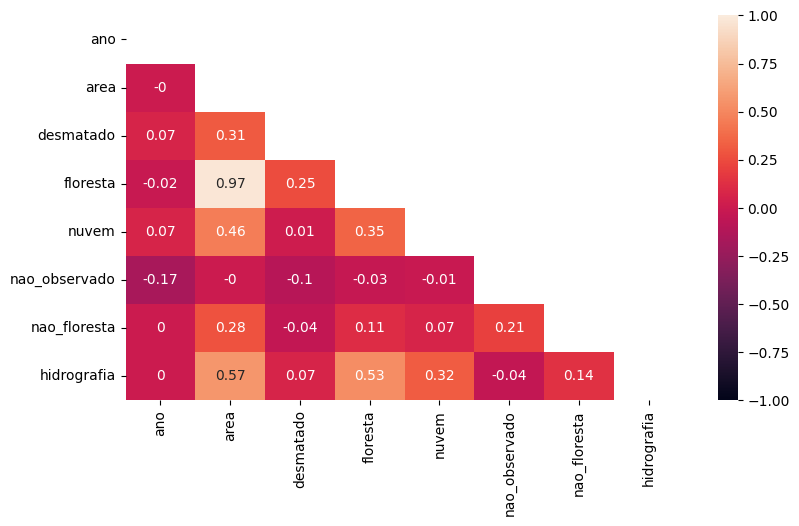

In [ ]:
selected_columns = ["ano", "area", "desmatado", "floresta", "nuvem", "nao_observado", "nao_floresta", "hidrografia", "estados", "municipios"]
new = df[selected_columns]

corr = round(new.corr(), 2)
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, annot=True)
plt.show()
# print(df.columns)



As we see from the correlation matrix above, there is a clear correlation between area and floresta (forest) which is expected since the more area the more forest it can have in. Besides there is a certain correlation between area and desmatado (deforestation) which is again expected.

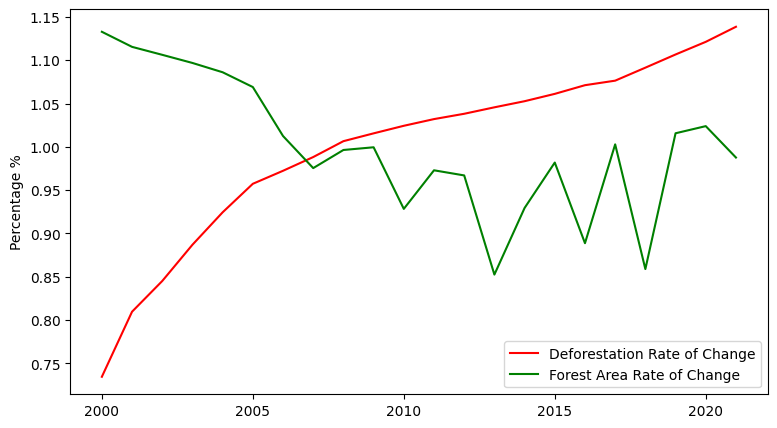

In [ ]:
lista1, anos1 = stats_year(df,"desmatado",True)
lista2, anos2 = stats_year(df,"floresta",True)
plt.figure(figsize=(9, 5))
plt.plot(list(anos1),lista1,"r", label="Deforestation Rate of Change")
plt.plot(list(anos2),lista2,"g", label="Forest Area Rate of Change")
plt.ylabel("Percentage %")
plt.legend()

The line plot shows to us that there is a anti-correlationship between deforestation and forest area. But this relationship is unclear from 2005 and beyond because the Forest Area starts to random variate it may be due to social-political response and bias measures

**Findind The Counties with more deforestation**

In [ ]:
anos = list(set(df["ano"]))
year = []
desmat = []
munic = []
esta = []
for ano in anos:

  new = df[df["ano"]==ano]
  new  = new.sort_values(by=['desmatado'], ascending=False)

  year.append(np.array(list(new.copy().iloc[0:10]["ano"])[:]))
  desmat.append(np.array(list(new.copy().iloc[0:10]["desmatado"])[:]))
  munic.append(np.array(list(new.copy().iloc[0:10]["municipios"])[:]))
  esta.append(np.array(list(new.copy().iloc[0:10]["estados"])[:]))

In [ ]:
dic = dict()
dic["ano"] = np.array(year).reshape(1,-1)[0]
dic["estado"] = np.array(esta).reshape(1,-1)[0]
dic["desmatado"] = np.array(desmat).reshape(1,-1)[0]
dic["municipio"] = np.array(munic).reshape(1,-1)[0]
novo = pd.DataFrame(dic)
novo

,ano,estado,desmatado,municipio
0,2000,Pará,7212.3,Paragominas
1,2000,Pará,7037.4,São Félix do Xingu
2,2000,Pará,5818.9,Marabá
3,2000,Mato Grosso,5520.7,Arinos
4,2000,Maranhâo,5373.3,Pindaré
...,...,...,...,...
215,2021,Pará,8616.0,Tucuruí
216,2021,Mato Grosso,8272.2,Arinos
217,2021,Pará,7528.9,São Félix do Xingu
218,2021,Pará,7353.5,Conceição do Araguaia


In [ ]:
muns = list(Counter(novo["municipio"]))
mat = []
for i in range(len(muns)):

  data = df[df["municipios"] == muns[i]]
  mat.append(stats_year(data,"desmatado",False)[0])

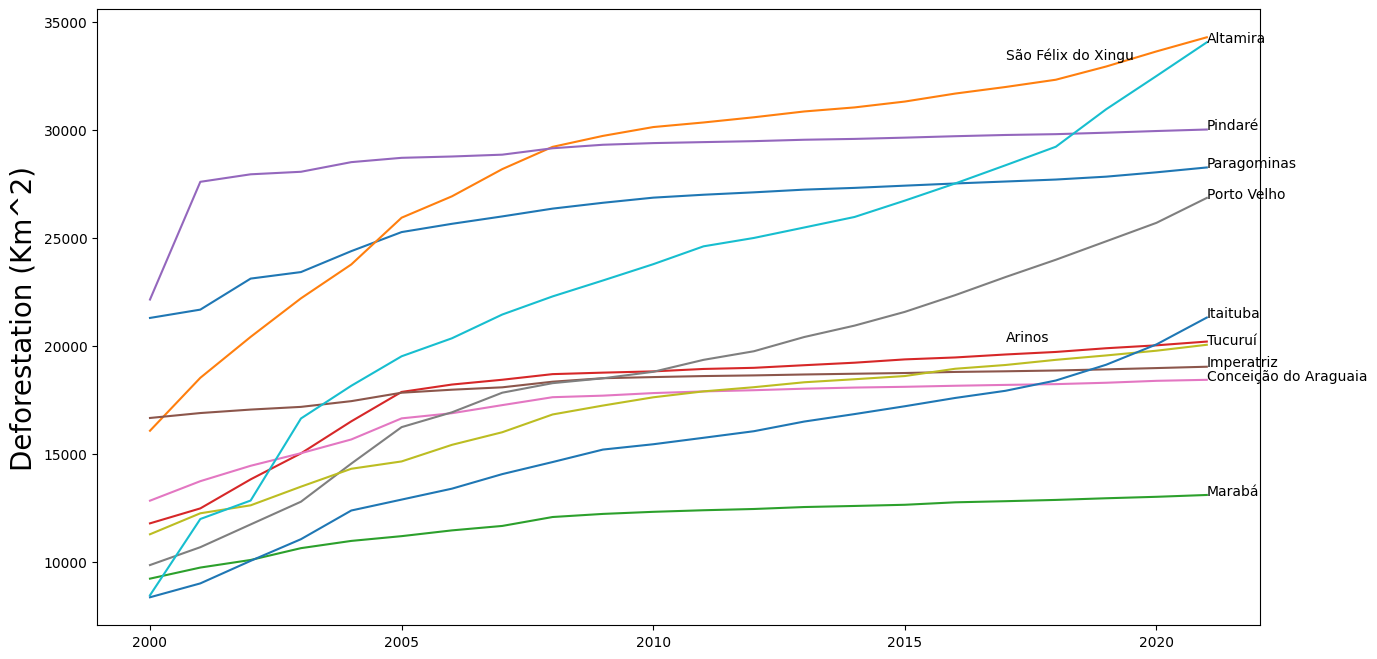

In [ ]:
plt.figure(figsize=(15, 8))
for i in range(len(muns)):

  if muns[i] == "São Félix do Xingu":
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1]-4, mat[i][-1]-1000, str(muns[i]), fontsize = 10)
  elif muns[i] == "Arinos":
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1]-4, mat[i][-1], str(muns[i]), fontsize = 10)
  else:
    plt.plot(list(set(novo.ano)),mat[i])
    plt.text(list(set(novo.ano))[-1], mat[i][-1], str(muns[i]), fontsize = 10)
plt.ylabel("Deforestation (Km^2)",fontsize = 20)
plt.show()

As shown above the counties: São Félix do Xingu, Altamira and Pindaré,. Are the ones with a upward tendency for deforestation from the lasts years. Some others (Paragominas, Arinos,Imperatriz, etc) reached a plateau. But none of them reached a downward tendency yet

**Predicting Future Deforestation**


Lets now use a Machine learning Algorithm to estimate the total states deforestation for 2022 and 2023. But first we need to make our traind set X from the previous dataset


In [ ]:
estd = list(Counter(df["estados"]))
mat = []
for i in range(len(estd)):

   data = df[df["estados"] == estd[i]]
   mat.append(stats_year(data,"desmatado",False)[0])

ano = []
est = []
for estado in estd:
  for i in range(2000,2022):
    ano.append(i)
    est.append(estado)

In [ ]:
d = {}
d["ano"] = ano
d["estado"] = est
d["desmatado"] = np.array(mat).reshape(1,-1)[0]

X = pd.DataFrame(d)
labels = list(Counter(X["estado"]))

X["estado"] = LabelEncoder().fit_transform(X["estado"])
Y = X.pop("desmatado")
labels_encod = list(Counter(X["estado"]))

**Model**

The model that I choose was a ensemble model with three models KNeighborsRegressor, SGDRegressor and BaggingRegressor. According to the big numbers law this three models mixied will result a more precision than use them separately.

**Fine tune Hyperparameters**


Before we train our ensembe lets tune separately hyperparameters to the three models using GridSearchCV and then use VotingRegressor to train the model.

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [ ]:
KN = KNeighborsRegressor()
bag = BaggingRegressor()

mod = GridSearchCV(estimator=KN,param_grid= {'n_neighbors':[1,2,3,4,5,6,7,8,9,10]},cv=2)

mod2 = GridSearchCV(estimator=bag,param_grid= {'n_estimators':[100,120,130,150,180]},cv=2)

mod3 = GridSearchCV(estimator=SGDRegressor(max_iter=1200,early_stopping=True),param_grid={'penalty':["l1","l2"]} ,cv=2)

vot = VotingRegressor(estimators=[("kn",mod),("bag",mod2),("est",mod3)])

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.1,random_state=True)

In [ ]:
vot.fit(X_train,y_train)
metrics.r2_score(y_test,vot.predict(X_test))

0.8917573980216331

Thus our R^2 is close to 0.89 which isn't bad considerig the training set size. Now lets predict the future states deforestation to 2022 and 2023.

In [ ]:
m = []
for i in labels_encod:
  for year in range(2022,2024):
      m.append([year,i])
pred = scaler.transform(m)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
predic = vot.predict(pred)

In [ ]:
Df = pd.DataFrame(d)
ano = [i for i in range(2000,2024)]

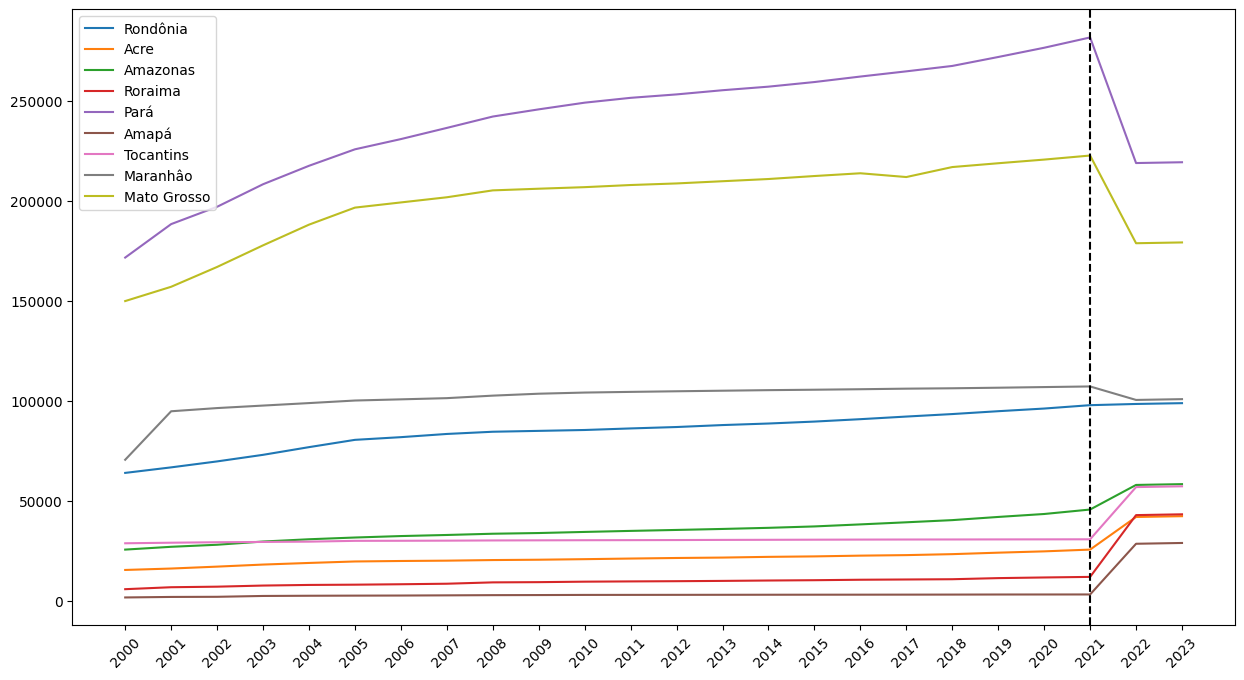

In [ ]:
plt.figure(figsize=(15,8))
c = 0
for i in labels:
  dat = Df[Df["estado"] == i]
  es = list(dat["desmatado"])
  es.append(predic[c])
  es.append(predic[c+1])
  plt.plot(ano,es,label = i)
  c+=2
plt.axvline(2021, color='k', linestyle='--')
plt.legend()
plt.xticks(ano, rotation=45)
plt.show()

**Final Conclusions**

From the finds shown previously we can conclude that.


Amazônia deforestation is currently in a high trend
The Counties São Félix do Xingu, Altamira and Pindaré have one of the highest deforestation rates, currently.
The states Pará and Mato Grosso have one of the highest deforestation rates, currentl